# <span style="color:brown"> **UNET Segmentation TRAINING**  
### *Keras / Tensorflow<span style="color:brown">  2*

*thomas.grenier@creatis.insa-lyon.fr*


Here, we train a UNet network.
We first need to go deeper in this architecture.

### <span style="color:brown"> **UNet**
This network is fully convolutional. It uses skip connections from the encoder side to the decoder side to preserve scale information.

This basic architecture can be changed in order to best perform on your data. 
In the following figure, the UNet is a 4 stages (or levels) UNet with 32 neurons on the first layer. These two features are the most significant for this architecture.

The encoder side consists of 2 convolution layers (convolution + activation + batch normalization) at each level.
Each level has twice more neurons than the previous one.
To jump from on level to the next one, a max pooling is performed which reduces the spatial size by 4.

The decoder processes symmetrically.
At each level, the features coming from the encoder level aside is concatenated to the features coming from the lower decoder level.
Then, as for the encoder, decoder levels consist of 2 convolution layers.
To adapt the spatial size from one stage to thee next one, an upsampling is performed.
This upsampling can be done by interpolation (https://keras.io/api/layers/reshaping_layers/up_sampling2d/) or by transposed convolution (https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) that someway learnt how to interpolate.

To produce the segmentation, all feature are first sumup to a *n* features map, where *n* is the number of classes, by *n* 1x1 convolution layer.
Then a *arg max* is done to produce the segmentation in the multi-classe case.
For binary segmentation, a simple threshold does the job.

<img src="figures/UNet.png" alt="UNet" style="width: 70%;"/>

In this UNet implementation, many parameters can be modified:
- The number of levels 
- The amount of feature at first level.
- Batch normalization can be activated or not
- Dropout amount (0.0 means no dropout)
- The upsampling strategy
- Activation functions
- Number of classes

Then, many hyper-parameters can be tuned for training.

In this notebook, you will train a UNet. 


### <span style="color:red"> Questions

- what was the architecture of the previously used network (in the test notebook) ? number of stages, features at first stage?...
- how many parameters have this network ?
- compare the code function *conv2d_block* of the network (located in keras_unet/models/custom_unet.py) with the network description.

## <span style="color:brown"> **1- System and basic imports**

In [1]:
!pip install medpy
!pip install tqdm
!pip install keras_unet
!pip install numpy==1.23

In [2]:
import glob
import os
import sys
from datetime import datetime

from tqdm import tqdm 

import numpy as np

!pip install scikit-learn
#import sklearn

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)
  
#prevent unwanted warning 
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

## <span style="color:brown"> **2- Important parameters**

In [3]:
WIDTH = 256
HEIGHT = 320


VALIDATION_RATIO = 0.1

JUPYTER_DISPLAY_ON = True # True or False used for displaying (or not) images

### Parameters to tune

In [4]:
# Network architecture related values 
NBLAYERS_UNET = 5      # <- number of levels [5]
NBFILTERS_L1_UNET = 16 # <- number of neurons for the first level [32]
DROPOUT_RATE = 0.1     # 0.0  to 1.0 [0.1]
KERNEL_SIZE = (3,3)    # (3,3)  (5,5) 
BATCHNORM_ON = False    # True or False [False]

CNN_ACTIVATION = 'relu' # relu, elu, selu, LeakyReLU, ...

# Training parameters
NBEPOCHS = 75          # Nb of Epoch  [20]
BATCH_SIZE = 8         # Number of sample in each batch (4 to 64) [16]
NBSTEPS_PER_EPOCH = 50  # nb of batches per epoch (1  to ...)  [50] (used for data augmentation)
NBPATIENCE_EPOCHS = 30  # nb of epoch after a minimum detection before stopping (early stop) [30]

### Name of the model file

In [5]:
model_path = './trained_model/'
model_name = 'Unet_1i_f' + str(NBFILTERS_L1_UNET) + '_l'+ str(NBLAYERS_UNET) +  '_k'+ str(KERNEL_SIZE[0]) + '_do' + str(DROPOUT_RATE) +'_act'+CNN_ACTIVATION + '_b' + str(BATCH_SIZE) +'_Std'
if BATCHNORM_ON == True:
    model_name = model_name + '_BN'
model_filename = model_path + model_name + '.h5'
print(" -> model_study : ", model_name)
print(" -> model_filename : ", model_filename)

 -> model_study :  Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std
 -> model_filename :  ./trained_model/Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std.h5


## <span style="color:brown"> **3- Session launch**

In [6]:
import tensorflow as tf

print(tf.__version__)
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Number of GPUs available :  1


In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7084892542981306404
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14285340672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13446899947423160195
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
xla_global_id: 416903419
]


## <span style="color:brown"> **4- Load data**

<span style="color:red">
    
**Before running the next cell**, you must have :
   1. downloaded the file ```dlss21_ho4_data.tar.gz``` 
   2. unziped the downloaded file in the directory of this notebook.
    
Data should be at ```./dlss21_ho4_data```    
    
## <span style="color:brown"> 4.1- Load files and set names

In [8]:
# train
train_flair_files = glob.glob("./data/train/images/*.png")
train_mask_files = glob.glob("./data/train/labels/*.png")

# test
test_flair_files = glob.glob("./data/test/images/*.png")
test_mask_files = glob.glob("./data/test/labels/*.png")



os.makedirs(model_path+model_name, exist_ok=True)  # save fig

logs_path = './logs/'
os.makedirs(logs_path, exist_ok=True)  # save fig

train_flair_files.sort()
train_mask_files.sort()

test_flair_files.sort()
test_mask_files.sort()

print( " training :  ", len(train_flair_files), len(train_mask_files) )
print( " testing :  ", len(test_flair_files), len(test_mask_files) )
nb_train = int( len(train_mask_files) * (1 - VALIDATION_RATIO) )

 training :   3013 3013
 testing :   365 365


__The previous cell should output 717 as training images and 208 as testing images.
If not, you must check where the data is.__

## <span style="color:brown"> 4.2- Randomly permute the data 

In [9]:
nb_display = 10
if JUPYTER_DISPLAY_ON == True:
    print( f" -> First {nb_display} train items ")
    [print(train_flair_files[i], train_mask_files[i]) for i in range(nb_display)]

    print( f" -> Last {nb_display} train items ")
    [print(train_flair_files[i], train_mask_files[i]) for i in range( len(train_mask_files)-nb_display, len(train_mask_files) )]

# permuation of inputs
permutation_train = np.random.permutation( len(train_mask_files))

# print("Permutation : ", permutation)


train_flair_files_rnd=[train_flair_files[i] for i in permutation_train]
train_mask_files_rnd=[train_mask_files[i] for i in permutation_train]

if JUPYTER_DISPLAY_ON == True:
    print( f" -> First PERMUTED {nb_display} train items ")
    [print(train_flair_files_rnd[i], train_mask_files_rnd[i]) for i in range(nb_display)]

    print( f" -> Last PERMUTED {nb_display} train items ")
    [print(train_flair_files_rnd[i], train_mask_files_rnd[i]) for i in range( len(train_mask_files)-nb_display, len(train_mask_files) )]

# Permuatation of test images : just to have more variability when displaying results... 
permutation_test = np.random.permutation( len(test_mask_files))
test_flair_files_rnd=[test_flair_files[i] for i in permutation_test]
test_mask_files_rnd=[test_mask_files[i] for i in permutation_test]   

 -> First 10 train items 
./data/train/images/01016SACH_seg1_054.png ./data/train/labels/01016SACH_seg1_054.png
./data/train/images/01016SACH_seg1_055.png ./data/train/labels/01016SACH_seg1_055.png
./data/train/images/01016SACH_seg1_056.png ./data/train/labels/01016SACH_seg1_056.png
./data/train/images/01016SACH_seg1_057.png ./data/train/labels/01016SACH_seg1_057.png
./data/train/images/01016SACH_seg1_058.png ./data/train/labels/01016SACH_seg1_058.png
./data/train/images/01016SACH_seg1_059.png ./data/train/labels/01016SACH_seg1_059.png
./data/train/images/01016SACH_seg1_060.png ./data/train/labels/01016SACH_seg1_060.png
./data/train/images/01016SACH_seg1_061.png ./data/train/labels/01016SACH_seg1_061.png
./data/train/images/01016SACH_seg1_062.png ./data/train/labels/01016SACH_seg1_062.png
./data/train/images/01016SACH_seg1_063.png ./data/train/labels/01016SACH_seg1_063.png
 -> Last 10 train items 
./data/train/images/08002CHJE_seg7_206.png ./data/train/labels/08002CHJE_seg7_206.png
./d

## <span style="color:brown"> 4.3- Functions to read, convert and resize the images and the masks

In [10]:
from keras_unet.utils import ReadImages, ReadMasks

## <span style="color:brown"> 4.4 - Define sets : train, validation and test

In [11]:
# reading files
X_train = ReadImages(train_flair_files_rnd[:nb_train], size=(WIDTH, HEIGHT))
y_train = ReadMasks(train_mask_files_rnd[:nb_train], size=(WIDTH, HEIGHT))

X_val = ReadImages(train_flair_files_rnd[nb_train:], size=(WIDTH, HEIGHT))
y_val = ReadMasks(train_mask_files_rnd[nb_train:], size=(WIDTH, HEIGHT))

X_test = ReadImages(test_flair_files_rnd, size=(WIDTH, HEIGHT))
y_test = ReadMasks(test_mask_files_rnd, size=(WIDTH, HEIGHT))


input_shape = (HEIGHT, WIDTH, 1)

100%|██████████| 365/365 [00:00<00:00, 3112.83it/s]


In [12]:
print(" Shape X_train and y_train : ", X_train.shape, y_train.shape)
print(" Shape X_val and y_val     : ", X_val.shape, y_val.shape)
print(" Shape X_test and y_test   : ", X_test.shape, y_test.shape)


print(" Type train: ", X_train.dtype, y_train.dtype)
print(" Type valid: ", X_val.dtype, y_val.dtype)
print(" Type test : ", X_test.dtype, y_test.dtype)

 Shape X_train and y_train :  (2711, 320, 256, 1) (2711, 320, 256, 2)
 Shape X_val and y_val     :  (302, 320, 256, 1) (302, 320, 256, 2)
 Shape X_test and y_test   :  (365, 320, 256, 1) (365, 320, 256, 2)
 Type train:  float32 float32
 Type valid:  float32 float32
 Type test :  float32 float32


## <span style="color:brown"> 4.4- Plot images

### 4.4.1 Display functions

In [13]:
from keras_unet.visualization import plot_overlay_segmentation, plot_compare_segmentation

### 4.4.2 Plot images with overlay (mask over original)

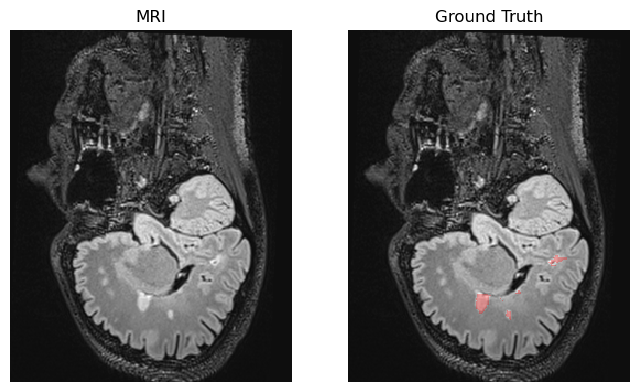

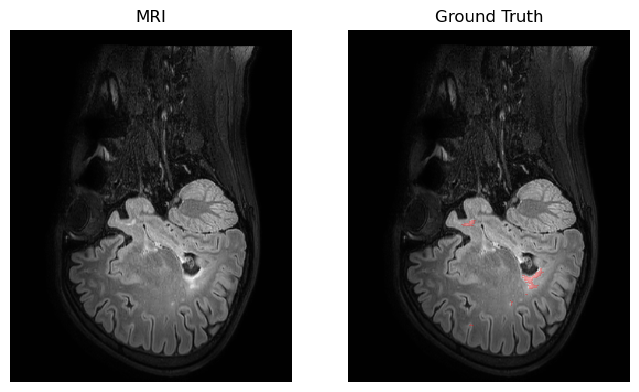

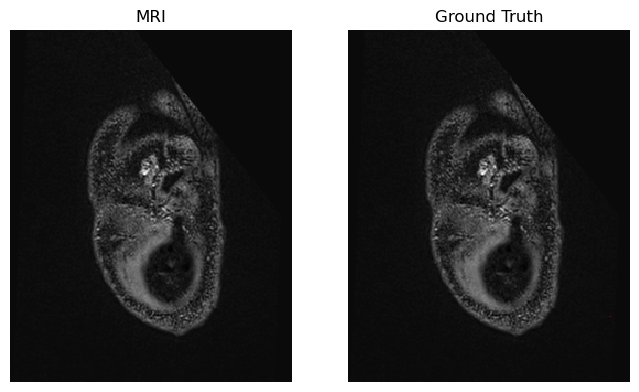

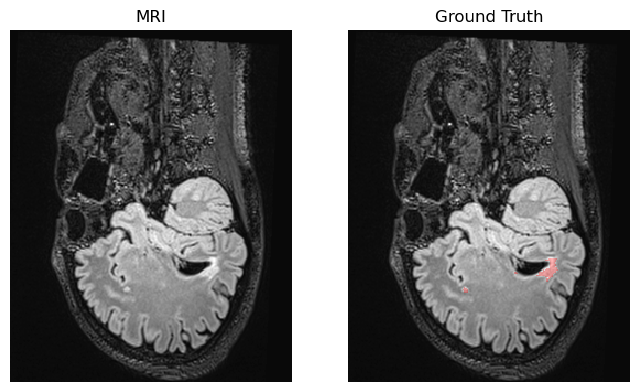

In [14]:
if JUPYTER_DISPLAY_ON == True:
    plot_overlay_segmentation(X_train[8:12], y_train[8:12])

## <span style="color:brown"> 4.7- Prepare a generator for data augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#        featurewise_center=True,
#        featurewise_std_normalization=True,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest',   # constant nearest, reflect or wrap
        validation_split=0)

class MyImageDataGenerator:
    def __init__(self, X, y, data_generator, batch_size):
        self.data_generator = data_generator
        self.batch_size=batch_size
        self.X = X
        self.y = y
        self.count = 0
        self.permutation = np.random.permutation(self.X.shape[0])
  
    def __iter__(self):
        self.count = 0
        self.permutation = np.random.permutation(self.X.shape[0])
        return self

    def __next__(self):
        if self.count > self.X.shape[0]//self.batch_size:
            self.count = 0
            self.permutation = np.random.permutation(self.X.shape[0])
 
        max_index = self.count*self.batch_size+self.batch_size # valeur index de fin
        if max_index > self.X.shape[0]-1:    # a t'on assez d'éléments ?
            max_index = self.X.shape[0]-1
        # permutation 
        X_rnd=np.asarray( [self.X[i] for i in self.permutation[self.count*self.batch_size:max_index]] )
        y_rnd=np.asarray( [self.y[i] for i in self.permutation[self.count*self.batch_size:max_index]] )
        
        for i in range(0,X_rnd.shape[0]):
            transf = self.data_generator.get_random_transform(img_shape = X_rnd.shape[1::] )   
            X_rnd[i,:,:,:] = self.data_generator.apply_transform( X_rnd[i,:,:,:], transform_parameters = transf)
            y_rnd[i,:,:,:] = self.data_generator.apply_transform( y_rnd[i,:,:,:], transform_parameters = transf)
        self.count += 1
        return X_rnd, y_rnd

In [16]:
my_train_generator = MyImageDataGenerator(X_train, y_train, datagen, BATCH_SIZE)
my_train_iter = iter(my_train_generator)

In [17]:
X,y = next(my_train_iter)
print(X.shape)
print(y.shape)

(8, 320, 256, 1)
(8, 320, 256, 2)


### Example of an augmented data batch 

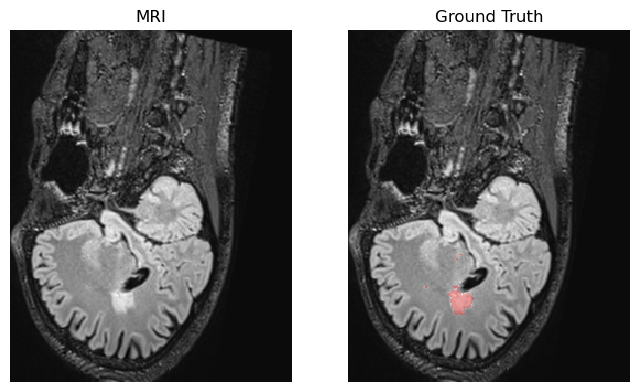

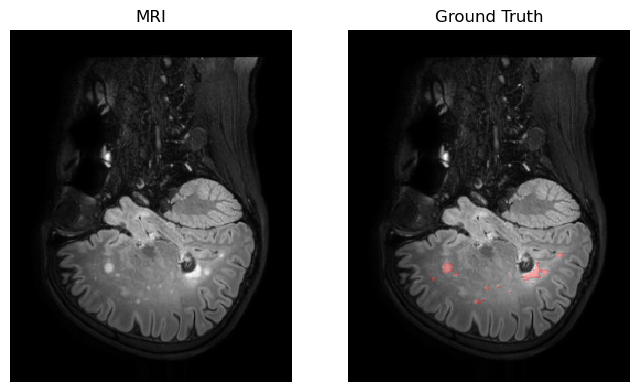

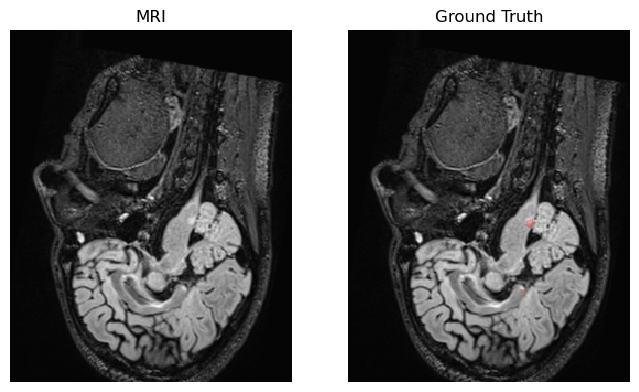

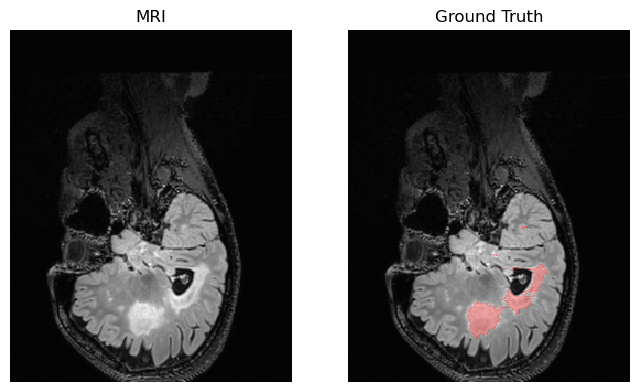

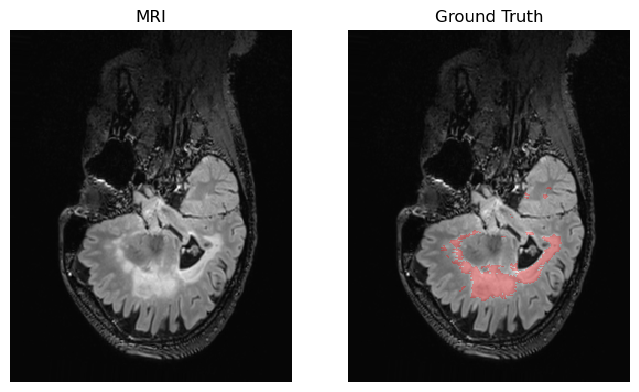

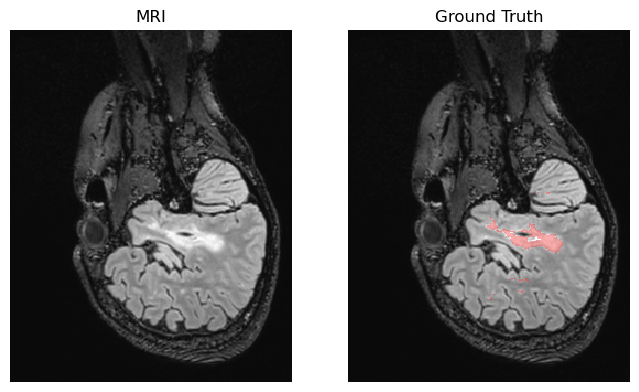

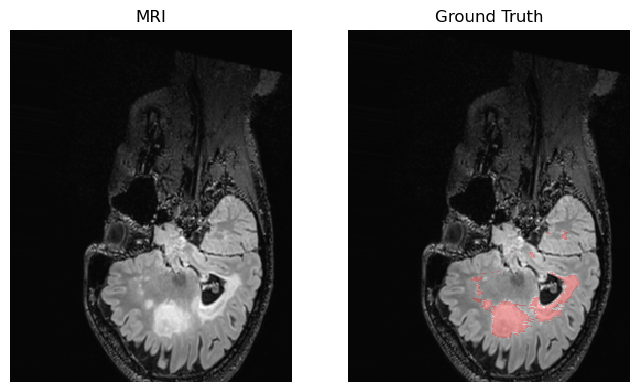

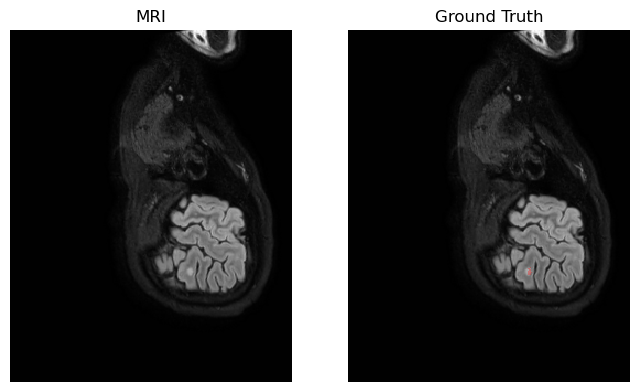

In [18]:
if JUPYTER_DISPLAY_ON == True:
    plot_overlay_segmentation(X, y)

## <span style="color:brown"> **5- Network and training**

## <span style="color:brown"> 5.1- Initialize network

### Import needed functions and reset the TF graph (safer, if you want to tune the model)

In [19]:
from keras_unet.models import custom_unet, xception_unet, lowfeaturedecoder_unet, attention_unet_smooth_network, attention_resunet_seg_decoder
from keras_unet.losses import dice_loss
from keras_unet.hausdorff_loss import Weighted_Hausdorff_loss

from tensorflow.keras import models
from tensorflow.keras import regularizers

### Create model

In [20]:
print(" input_shape : ", input_shape)

if 'model' in locals(): 
    print("deleting model")
    del model
    
model = custom_unet(
    input_shape,
    use_batch_norm=BATCHNORM_ON,  
    num_classes=y_train[0].shape[-1],
    filters=NBFILTERS_L1_UNET, 
    dropout=DROPOUT_RATE,
    num_layers=NBLAYERS_UNET,
    kernel_size=KERNEL_SIZE,
    cnn_activation=CNN_ACTIVATION,
    output_activation='softmax',
    dropout_type='simple', # spatial or  simple
    kernel_initializer='he_normal',
    kernel_regularizer=None # regularizers.l1(0.001)  # =None   for no regularization
    )     

 input_shape :  (320, 256, 1)


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 320, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

## <span style="color:brown"> 5.2- Compile the model

### Create callbacks for interactions during training

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

print("model_filename : ", model_filename)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_dice_coef', #'val_loss'
    mode ='max', # use 'min' or 'auto' if val_loss
    save_best_only=True
)

callback_earlystopping = EarlyStopping(
    monitor='val_dice_coef', #'val_loss'
    mode ='max', # use 'min' or 'auto' if val_loss
    patience=NBPATIENCE_EPOCHS,
    restore_best_weights=True  # at the end of fitting, restore best model weights 
)

logdir = "./logs/scalars/" + model_name + '_' + datetime.now().strftime("%Y-%m-%d_%Hh%M'")
print("logdir : ", logdir)
callback_tensorbooard = TensorBoard(
    log_dir=logdir, profile_batch=0
)

model_filename :  ./trained_model/Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std.h5
logdir :  ./logs/scalars/Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std_2024-01-30_13h43'


### Compile the model

i.e. : Set optimization algorithm, loss, metrics, ...

In [23]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras_unet.metrics import multi_dice_coef, dice_coef, iou, iou_thresholded
from keras_unet.losses import dice_loss, adaptive_loss
from tensorflow.keras.callbacks import TensorBoard

initial_learning_rate = 0.001

# Optional scheduler to decrease learning rate according iterations or epoches
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=10000,
#    decay_rate=0.96,
#    staircase=True)

cce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.0)

model.compile(
    loss=cce_loss,  # or 'categorical_crossentropy'
    #loss=dice_loss,      # <- other loss you can test
    #loss=adaptive_loss,
    
    optimizer=Adam(learning_rate=initial_learning_rate),  # 0.0001
    #optimizer=RMSprop(learning_rate=initial_learning_rate, rho=0.9, momentum=0.8, epsilon=1e-07, centered=True),  # <- other optimizer you can test
    #optimizer=SGD(learning_rate=initial_learning_rate, momentum=0.99),  # 0.01 
      
    metrics=[dice_coef]
)

## <span style="color:brown"> 5.3- Fit the model (train)

Watch evolution of loss on epoches and time elapsed per epoch.
If too long, you can stop the execution.

In [24]:
history = model.fit(
    X_train, y_train,  # use the 'original' images 
#    my_train_iter,           # use the images augmented by generator
#    steps_per_epoch=NBSTEPS_PER_EPOCH,  # uncomment when using 'myiter' (a data generator)
    batch_size=BATCH_SIZE,
    epochs=NBEPOCHS,
    validation_data=(X_val, y_val), 
    shuffle=True,
    verbose=1,
    callbacks=[callback_earlystopping, callback_checkpoint, callback_tensorbooard]
)

Epoch 1/75
339/339 [==============================] - ETA: 0s - loss: 0.0224 - dice_coef: 0.7353
Epoch 1: val_dice_coef improved from -inf to 0.65910, saving model to ./trained_model/Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std.h5
339/339 [==============================] - 49s 119ms/step - loss: 0.0224 - dice_coef: 0.7353 - val_loss: 0.0315 - val_dice_coef: 0.6591
Epoch 2/75
339/339 [==============================] - ETA: 0s - loss: 0.0085 - dice_coef: 0.8047
Epoch 2: val_dice_coef improved from 0.65910 to 0.77023, saving model to ./trained_model/Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std.h5
339/339 [==============================] - 37s 109ms/step - loss: 0.0085 - dice_coef: 0.8047 - val_loss: 0.0121 - val_dice_coef: 0.7702
Epoch 3/75
339/339 [==============================] - ETA: 0s - loss: 0.0068 - dice_coef: 0.8256
Epoch 3: val_dice_coef improved from 0.77023 to 0.77296, saving model to ./trained_model/Unet_1i_f16_l5_k3_do0.1_actrelu_b8_Std.h5
339/339 [==============================] - 37s 

## <span style="color:brown"> 5.4- Plot training and validation history

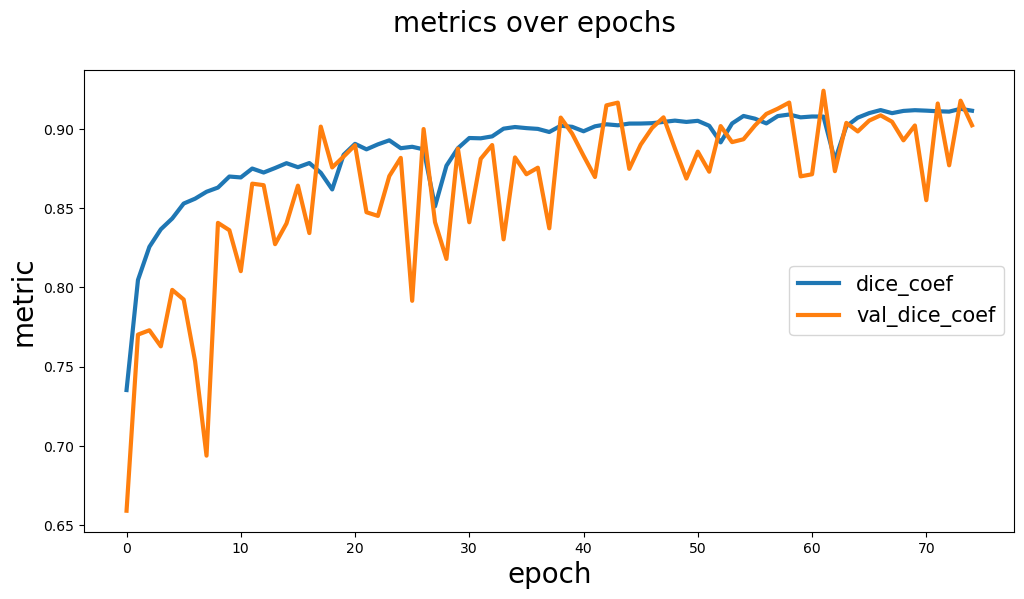

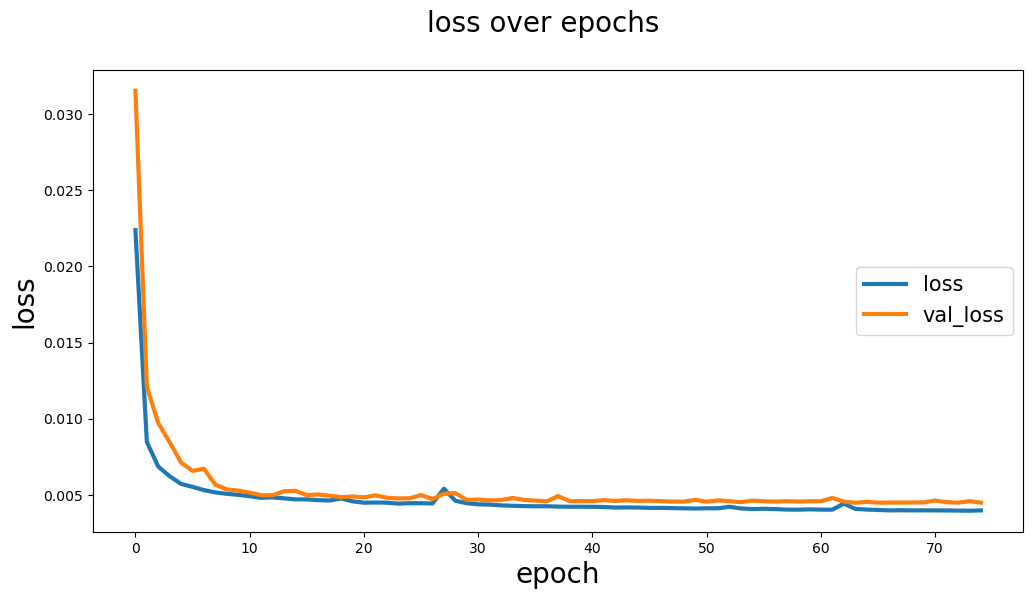

In [25]:
from keras_unet.visualization import plot_segm_history

plot_segm_history(history,  metrics=['dice_coef', 'val_dice_coef'])

## <span style="color:brown"> 5.5- Plot training and validation during training with Tensorboard (NOT ON SATURN CLOUD)

You can use tensorboard to watch loss and metric evolutions during training.
To do so you can :
  1. start a terminal in jupyter lab (File -> New launcher then 'Terminal'
  2. in this terminal execute : ```$ tensorboard  --logdir ./logs/scalars/  ```
    

## <span style="color:brown"> **6- Verify the model**

## <span style="color:brown"> 6.1- Plot original + ground truth + pred + overlay (pred on top of original)

In [26]:
y_pred = model.predict(X_val, batch_size=1, verbose=1) # GPU Size 
loss, dice_coef = model.evaluate(x=X_val, y=y_val, batch_size=1, verbose=1) # 
print(f"loss : {loss}   Dice_coeff : {dice_coef}")

302/302 [==============================] - 2s 6ms/step - loss: 0.0045 - dice_coef: 0.9023
loss : 0.004481131676584482   Dice_coeff : 0.9022766351699829


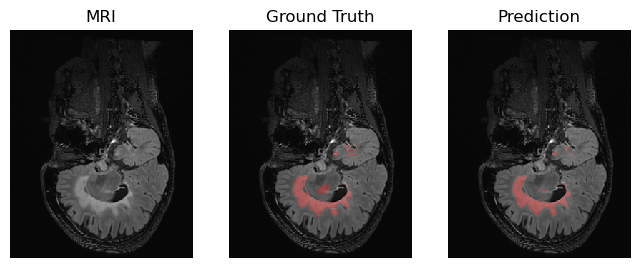

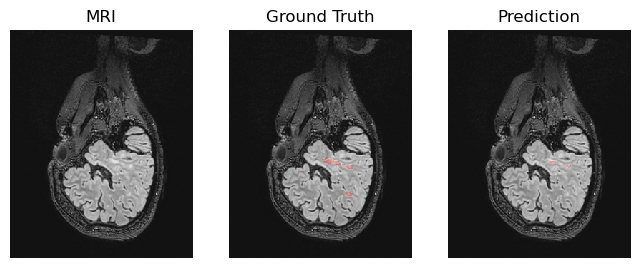

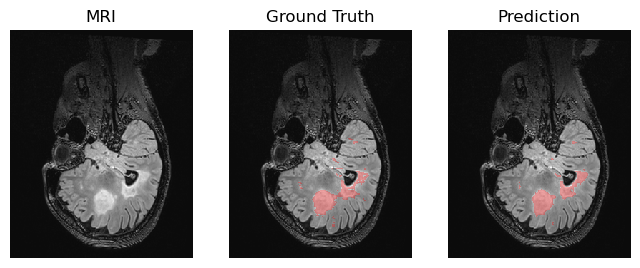

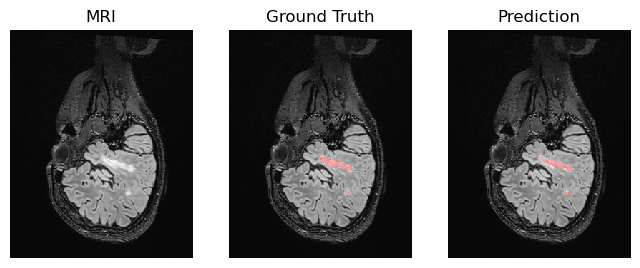

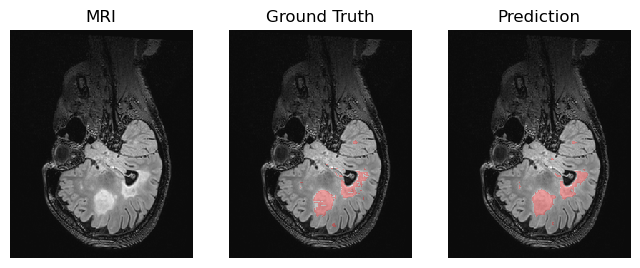

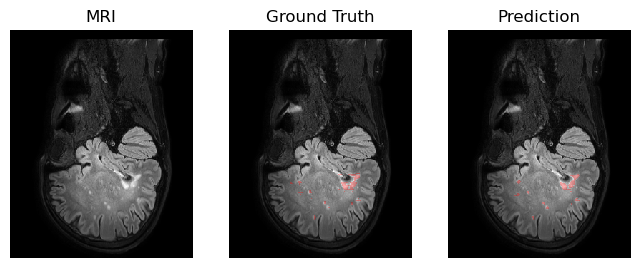

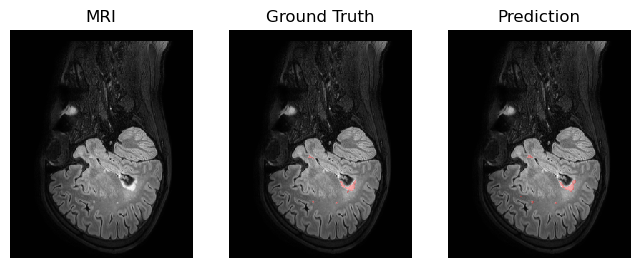

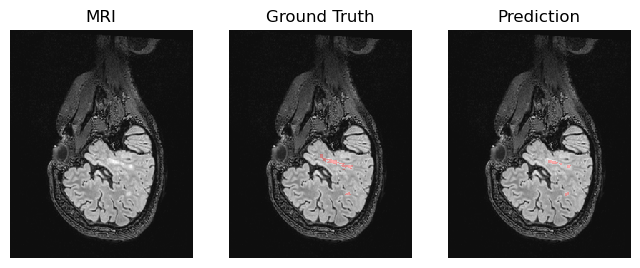

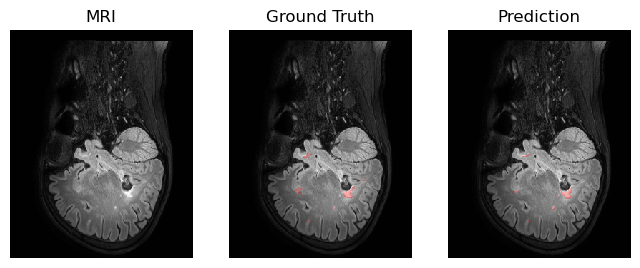

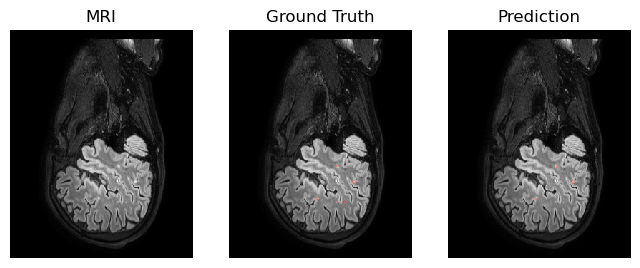

In [27]:
N_b = 0
N_e = 10
plot_compare_segmentation(X_val[N_b:N_e], y_val[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

## <span style="color:red"> Questions

- Run 20 more epoches and display curves and results again (... run the cells after §5.3). Are the results better ?
- And 20 more ? 
- Train this network to have a DICE greater than 0.90. 
- Are the segmentation results convincing on the validation images ? Is this assessment correct?
- Execute the next 2 cells : evaluation is performed on the test set ...

## <span style="color:brown"> 6.2- Inference on test images

In [28]:
y_pred = model.predict(X_test, batch_size=1, verbose=1) # GPU Size
loss, dice_coef = model.evaluate(x=X_test, y=y_test, batch_size=1, verbose=1) # 
print(f"loss : {loss}   Dice_coeff : {dice_coef}")

365/365 [==============================] - 2s 6ms/step - loss: 0.0034 - dice_coef: 0.8384
loss : 0.003354438114911318   Dice_coeff : 0.8383659720420837


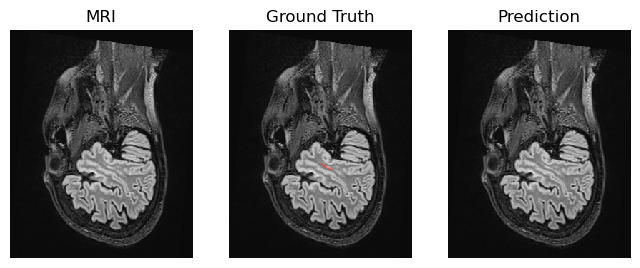

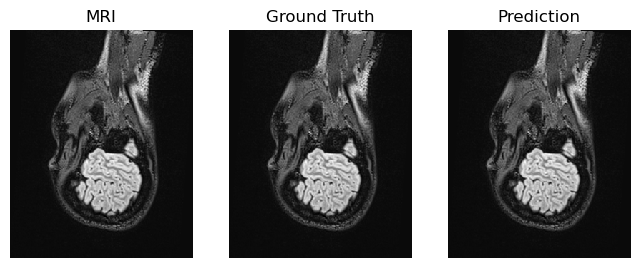

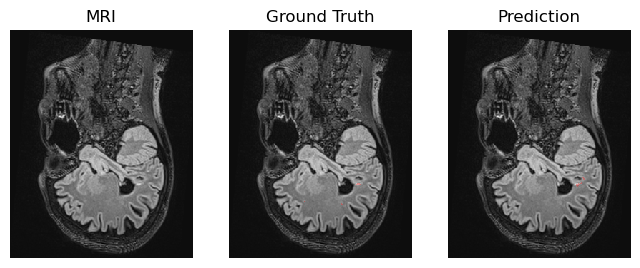

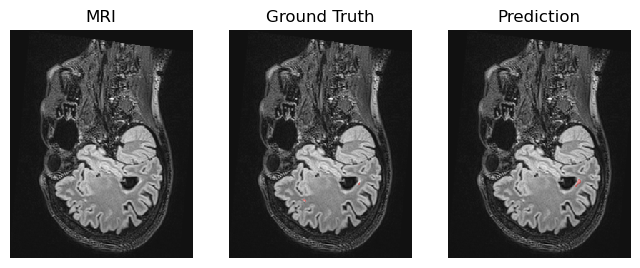

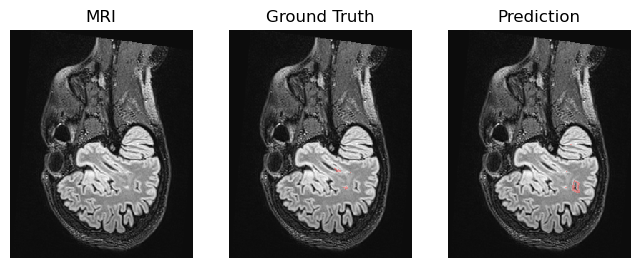

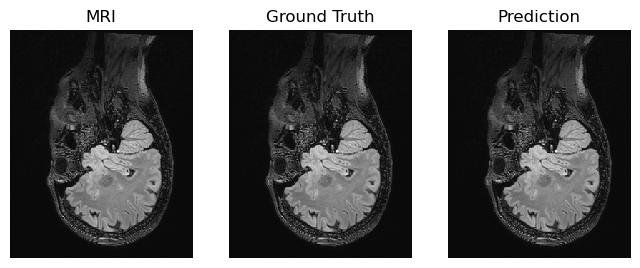

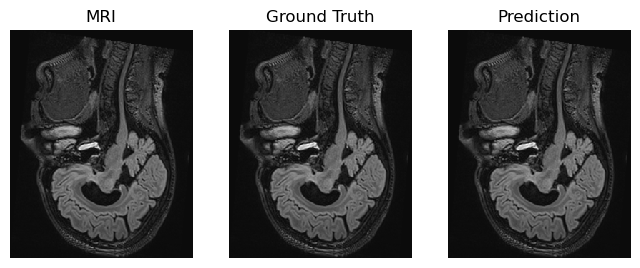

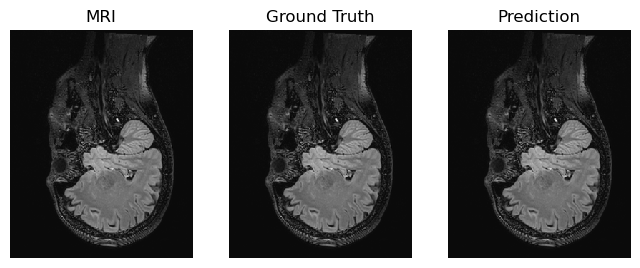

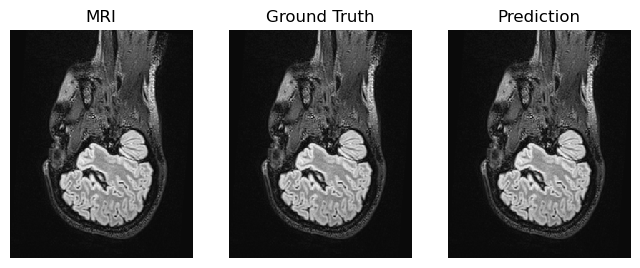

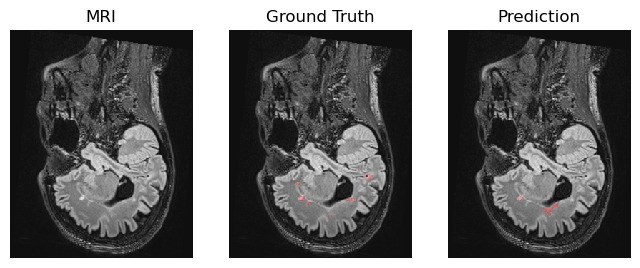

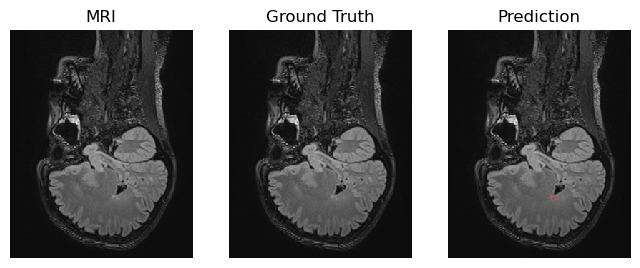

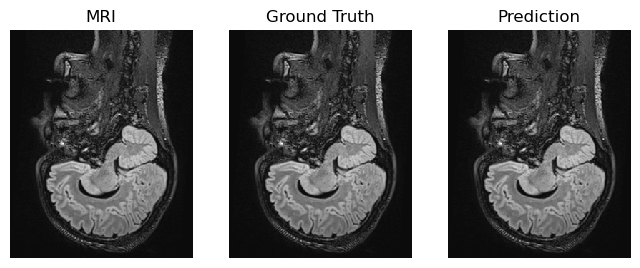

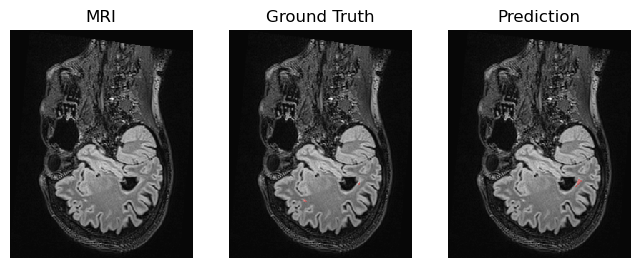

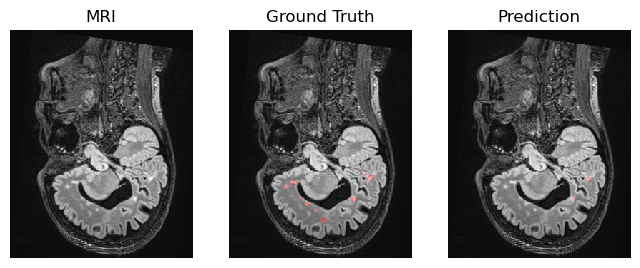

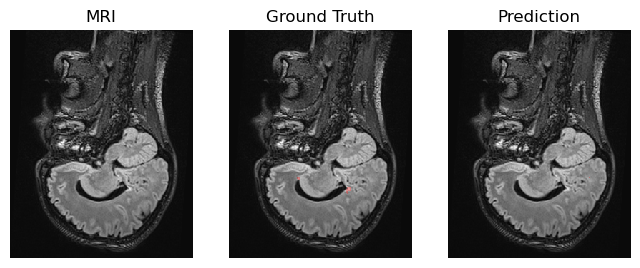

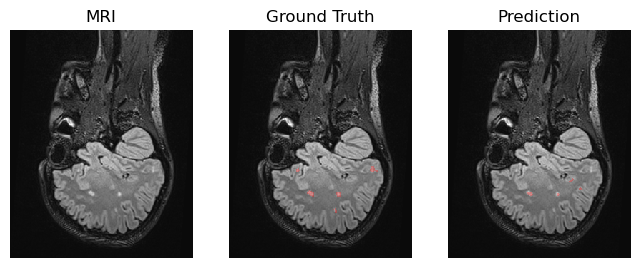

In [29]:
N_b = 114
N_e = 130
plot_compare_segmentation(X_test[N_b:N_e], y_test[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

In [30]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set

In [31]:
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y_test, y_pred)

100%|██████████| 365/365 [00:03<00:00, 110.23it/s]


In [32]:
print("dice_all", dice_all)
print("hausdorff", hausdorff_all)
print("assd", assd_all)

dice_all [0.2786362 0.2786362]
hausdorff [48.82956 48.82956]
assd [21.279837 21.279837]


## <span style="color:red"> Questions

- Optimize the training paramters to improve segmentation results (according the validation set iou thresholded value): regularizations, data sets size, hyper parameters (you can enable regularizations (drop out, Batch Norm, L1 or L2 on weights). Note that you can't check all configurations, so plan tests with your collegues ! (and have a look at AutoML)
    
- Ok, the above training is long ;) So during training, display some information using Tensorboard: model shape and real time training curves.
    
- What is early stopping and what it should avoid? Discuss the evolution of losses and metrcis during training.

## <span style="color:brown"> **7- Accessing the learned filters**
    
For understanding effect of layers, it can be of interest to display filters learned by the network.

In [33]:
print(" -> number of layers : ", len(model.layers) )
for a in range(1,len(model.layers)):
    print(f" index : {a}, layer name : {model.layers[a].name}") 

 -> number of layers :  51
 index : 1, layer name : conv2d
 index : 2, layer name : dropout
 index : 3, layer name : conv2d_1
 index : 4, layer name : dropout_1
 index : 5, layer name : max_pooling2d
 index : 6, layer name : conv2d_2
 index : 7, layer name : dropout_2
 index : 8, layer name : conv2d_3
 index : 9, layer name : dropout_3
 index : 10, layer name : max_pooling2d_1
 index : 11, layer name : conv2d_4
 index : 12, layer name : dropout_4
 index : 13, layer name : conv2d_5
 index : 14, layer name : dropout_5
 index : 15, layer name : max_pooling2d_2
 index : 16, layer name : conv2d_6
 index : 17, layer name : dropout_6
 index : 18, layer name : conv2d_7
 index : 19, layer name : dropout_7
 index : 20, layer name : max_pooling2d_3
 index : 21, layer name : conv2d_8
 index : 22, layer name : dropout_8
 index : 23, layer name : conv2d_9
 index : 24, layer name : dropout_9
 index : 25, layer name : max_pooling2d_4
 index : 26, layer name : conv2d_10
 index : 27, layer name : dropou

In [34]:
N_l = 1 # Remember that some layers have no weights !
print("-> Get config : ", model.layers[N_l].get_config())  # get whole information of the layer (config of the layer)

-> Get config :  {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [35]:
print("-> Get shape : ", model.layers[N_l].get_weights()[0].shape) #ok this line works only if some weights exist (X,Y,C,Neurons)
w = model.layers[N_l].get_weights()[0][:,:,0,:]
print(w.shape[2])

-> Get shape :  (3, 3, 1, 16)
16


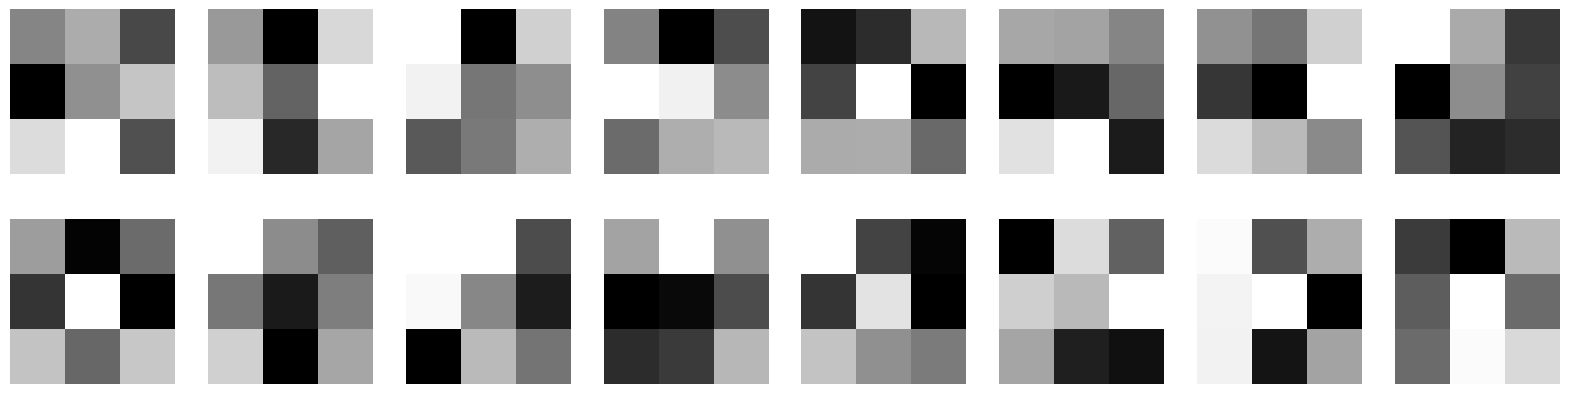

In [36]:
nb_filters = w.shape[2]
nb_filters_per_line = 8   # 
if nb_filters > 256: nb_filters = 256
if nb_filters < 9: nb_filters_per_line = nb_filters
#assert nb_filters < 256
plt.subplots(nb_filters//nb_filters_per_line,nb_filters_per_line,figsize=(20,5))
for i in range(1,nb_filters+1,1):  
    plt.subplot(nb_filters//nb_filters_per_line,nb_filters_per_line,i) # current plot is i
    plt.imshow(w[:,:,i-1], interpolation='none', cmap='gray')
    plt.axis('off')

## <span style="color:red"> Question
  
- Visualize and discuss the filters of the first CNN after the first maxpooling (conv2d_3 layer). Justify its shape.

## <span style="color:brown"> **8- Observing the intermediate images**
    
Intermediate images are images at the output of layers.
This task can be done efficiently using a second network that just copies all outputs of our network (the variable is *model*) to allow us displaying the activations.

In [37]:
layer_outputs = [layer.output for layer in model.layers[1:]]  # skip input for fed problem
print( len(layer_outputs) )
# Extracts the outputs 
activation_model  = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

50


Here we select an image (in the validation set... it can be changed!)

In [38]:
Index_img_to_display = 9
print(X_val[Index_img_to_display:Index_img_to_display+1,:,:,:].shape)
activations = activation_model.predict(X_val[Index_img_to_display:Index_img_to_display+1,:,:,:])

(1, 320, 256, 1)
1/1 [==============================] - 0s 334ms/step


Here we select an activation output. For convenience, indexes of layers have been preserved from 0 to N (0 means input and is not mapped to this model) 

In [39]:
Index_Output_Layer = 1 #N_l
first_layer_activation = activations[Index_Output_Layer - 1]
print(first_layer_activation.shape)

(1, 320, 256, 16)


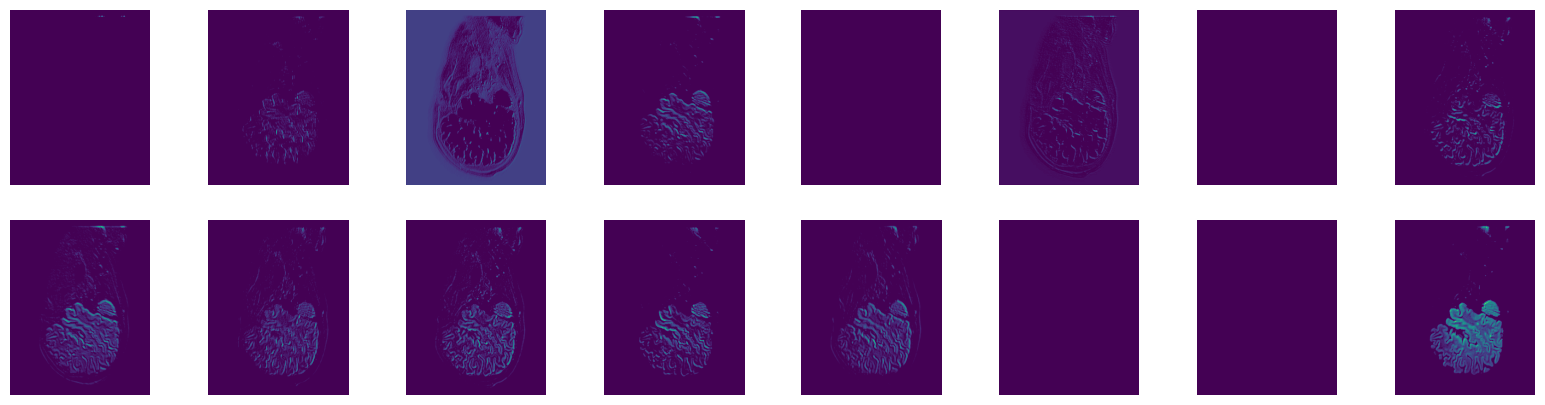

In [40]:
#plt.figure(figsize=(10,10))
#plt.imshow(first_layer_activation[0, :, :, 2], cmap='viridis')  

nb_filters =first_layer_activation.shape[3]
nb_filters_per_line = 8   # 
if nb_filters > 256: nb_filters = 256
if nb_filters < 9: nb_filters_per_line = nb_filters
#assert nb_filters < 256
plt.subplots(nb_filters//nb_filters_per_line,nb_filters_per_line,figsize=(20,5))
for i in range(1,nb_filters+1,1):  
    plt.subplot(nb_filters//nb_filters_per_line,nb_filters_per_line,i) # current plot is i
    plt.imshow(first_layer_activation[0, :, :, i-1], interpolation='bilinear', cmap='viridis' )#, vmin=0, vmax=1)
    plt.axis('off')

## <span style="color:red"> Questions
  
- Visualize and discuss the filters conv2d_3 layer (the first CNN after the first maxpooling). Justify its shape.
- Visualize and discuss the last filter.


## <span style="color:red"> Questions, to finish ... 
 
- Modify the network to use the 3 MRI sequences as input (e8, e5 and e2). Follow the training with tensorboard. Is DICE improved?

- Modify the code to use the Xception_unet with ADAM optimizer. First change the __model_filename__ string to facilitate comparisons with previous training.
 
- How much time to manual segment an image ? Why it is critical to have good (expert, consistent) annotated images? With no more new data, what can be done to __augment__ our train data set?


## <span style="color:brown"> **Following cells are some help and information**

### <span style="color:brown"> Tensorboard (reminder)

Tensorboard allows many training, graph, images supervision using a simple web navigator: you just have to connect to the server.
Many ways to use it whitin jupyter notebook or not.

The easyest way is to launch tensorboard in the command line (stand alone program)
``` bash
tensorboard --logdir ./logs/scalars/  --bind_all
```
Adapt the logdir directory to point out desired files (this exmple work with this notebook)
With the __bind_all__ option, all internet interfaces will expose the tensorboard server.
Then, you can connect with 127.0.0.1:6006 or other interfaces which are listed when tensorboard started
(the port number can be changed with --port option, --host can be used to specify a dedicated IP for the server).

It is also possible to incoporate tensorboard directly in jupyter-lab using an extension or using it as a cell.

- As cell (using magics): https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
- As extension (require dedicated installation) : https://github.com/chaoleili/jupyterlab_tensorboard   or https://github.com/HFAiLab/jupyterlab_tensorboard_pro  

### <span style="color:brown"> Hints for usage of 3 MRI as input

- **first**, the input image shape has now 3 channels:
``` python
input_shape = (IMG_SIZE, IMG_SIZE, 3) # see the "3" instead of 1
```

- **second** we need to build the input tensor by concatenating the three MRI:
``` python
concat_train = tf.keras.layers.Concatenate()([X_train_e8, X_train_e5, X_train_e2])
concat_val = tf.keras.layers.Concatenate()([X_val_e8, X_val_e5, X_val_e2])
print(concat_train.shape)
plt.imshow(concat_train[0]) # display in color :p
```

- **third**, train the model. Note that it not necessary to modify the architectucture as only the input shape evolve (and thus only the number of parameters of the first layer)
``` python
history = model.fit(
    concat_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NBEPOCHS,
    validation_data=(concat_val, y_val),
    shuffle=True,
    verbose=1,
    callbacks=[ callback_earlystopping, callback_checkpoint, callback_tensorbooard]
)
```
- **fourth**, remind to adapt the prediction on the concatenated tensors!
``` python
y_pred = model.predict(concat_val, batch_size=1, verbose=1) # GPU Size
loss, dice_coef = model.evaluate(x=concat_val, y=y_val, batch_size=1, verbose=1) # 
print(f"loss : {loss}   Dice_coeff : {dice_coef}")
print(y_pred.shape)
```
